In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from sqlalchemy import create_engine
from config import username, password

engine = create_engine('postgresql://{}:{}@localhost:5432/cali_renewable_db'.format(username,password))
con = engine.connect()

sql_prod = '''Select * From  "Production".hourlyrenewable'''

full_data = pd.read_sql(sql=sql_prod,con=con)
full_data['date'] = pd.to_datetime(full_data['date'])

display(full_data.head())

sql_demand = 'Select * From "Demand".hourlydemand'
demand_data = pd.read_sql(sql=sql_demand, con=con)

demand_data['date'] = pd.to_datetime(demand_data['date'])
demand_data['YEAR'] = demand_data['date'].dt.year

demand_data.head()

timestamp       date  Hour  TOTAL  SOLAR TOTAL  SOLAR PV  \
0 2015-06-01 00:00:00 2015-06-01     1   4669            0         0   
1 2015-06-01 01:00:00 2015-06-01     2   4396            0         0   
2 2015-06-01 02:00:00 2015-06-01     3   4197            0         0   
3 2015-06-01 03:00:00 2015-06-01     4   4059            0         0   
4 2015-06-01 04:00:00 2015-06-01     5   3694            0         0   

   SOLAR THERMAL  WIND TOTAL  GEOTHERMAL  BIOMASS  BIOGAS  SMALL HYDRO  
0              0        2942        1038      321     209          159  
1              0        2708        1040      316     210          122  
2              0        2509        1039      319     209          121  
3              0        2372        1035      320     209          123  
4              0        1973        1035      317     208          161

timestamp       date  Hour   DEMAND  YEAR
0 2019-12-29 11:00:00 2019-12-29    11  21305.0  2019
1 2019-12-29 10:00:00 2019-12-29    10  21638.0  2019
2 2019-12-29 09:00:00 2019-12-29     9  21745.0  2019
3 2019-12-29 08:00:00 2019-12-29     8  21859.0  2019
4 2019-12-29 07:00:00 2019-12-29     7  21586.0  2019

In [2]:
from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler

In [3]:
#still messing around with extra regressors 



full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 3) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month <= 9))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

scaler = StandardScaler()

dd['cap'] = 17000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2014'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))
print(y.iloc[0:5].sum())
print(y.iloc[5:8].sum())
dd_train.info()

ds         y       cap  on_season  off_season   daytime  \
0 2015-06-01 00:00:00  8.448700  9.740969       True       False -0.795932   
1 2015-06-01 01:00:00  8.388450  9.740969       True       False -0.795932   
2 2015-06-01 02:00:00  8.342125  9.740969       True       False -0.795932   
3 2015-06-01 03:00:00  8.308692  9.740969       True       False -0.795932   
4 2015-06-01 04:00:00  8.214465  9.740969       True       False -0.795932   
5 2015-06-01 05:00:00  8.228978  9.740969       True       False -0.795932   
6 2015-06-01 06:00:00  8.365905  9.740969       True       False -0.795932   
7 2015-06-01 07:00:00  8.716372  9.740969       True       False -0.795932   

   on_seasonr  
0           1  
1           1  
2           1  
3           1  
4           1  
5           1  
6           1  
7           1

21015
14148
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 7 columns):
ds            31392 non-null datetime64[ns]
y             31392 non-null float64
cap           31392 non-null float64
on_season     31392 non-null bool
off_season    31392 non-null bool
daytime       31392 non-null float64
on_seasonr    31392 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB


In [4]:
model = Prophet(changepoint_range=.65,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.7)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=8)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=8)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
#model.add_regressor('equinox')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_train)



In [5]:
future = model.make_future_dataframe(periods=365*24,freq='1H')
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 20000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)

forcast = model.predict(future)

ds     trend       cap  yhat_lower  yhat_upper  \
0 2015-06-01 00:00:00  8.373352  9.903488    8.155590    8.751289   
1 2015-06-01 01:00:00  8.373365  9.903488    8.141675    8.705149   
2 2015-06-01 02:00:00  8.373377  9.903488    8.077757    8.685689   
3 2015-06-01 03:00:00  8.373390  9.903488    8.069128    8.669220   
4 2015-06-01 04:00:00  8.373402  9.903488    8.055410    8.624465   

   trend_lower  trend_upper  additive_terms  additive_terms_lower  \
0     8.373352     8.373352        0.065748              0.065748   
1     8.373365     8.373365        0.056069              0.056069   
2     8.373377     8.373377        0.031092              0.031092   
3     8.373390     8.373390       -0.002523             -0.002523   
4     8.373402     8.373402       -0.034383             -0.034383   

   additive_terms_upper  ...  on_seasonr  on_seasonr_lower  on_seasonr_upper  \
0              0.065748  ...    0.107829          0.107829          0.107829   
1              0.056069  ...    0.107829          0.107829          0.107829   
2              0.031092  ...    0.107829          0.107829          0.107829   
3             -0.002523  ...    0.107829          0.107829          0.107829   
4             -0.034383  ...    0.107829          0.107829          0.107829   

     yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  0.354174      0.354174      0.354174                   0.0   
1  0.351800      0.351800      0.351800                   0.0   
2  0.349306      0.349306      0.349306                   0.0   
3  0.346712      0.346712      0.346712                   0.0   
4  0.344042      0.344042      0.344042                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  8.439100  
1                         0.0                         0.0  8.429433  
2                         0.0                         0.0  8.404469  
3                         0.0                         0.0  8.370867  
4                         0.0                         0.0  8.339019  

[5 rows x 32 columns]

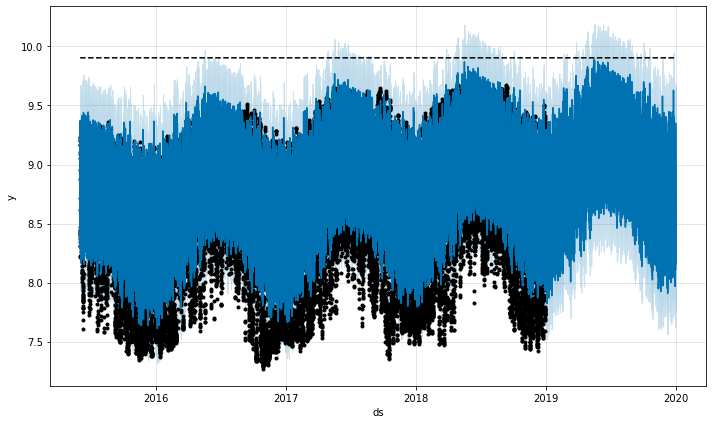

In [6]:
model.plot(forcast)
forcast.head()


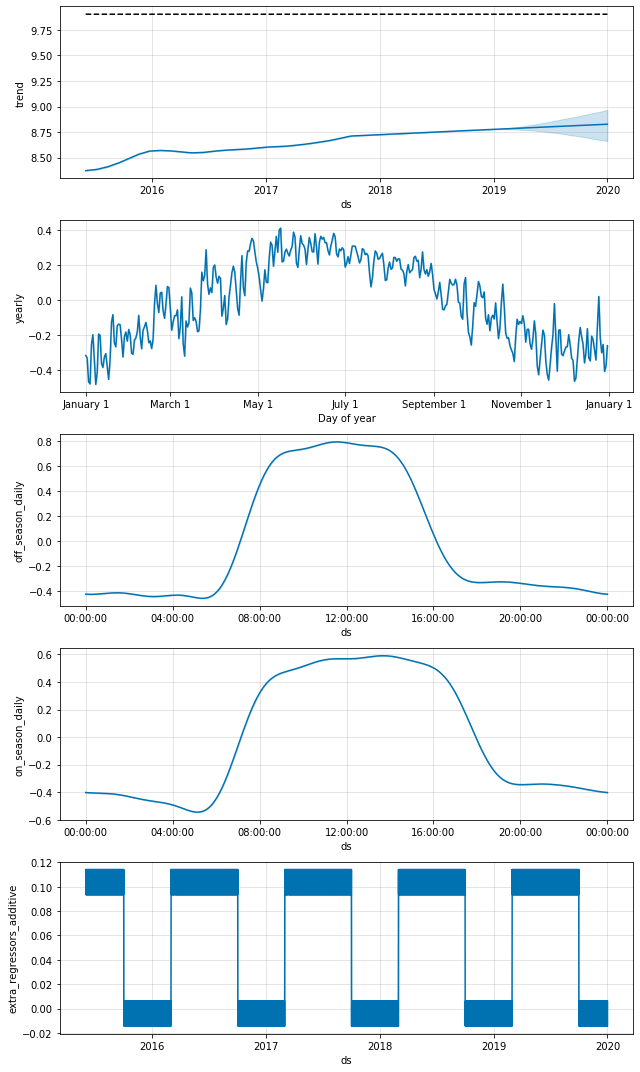

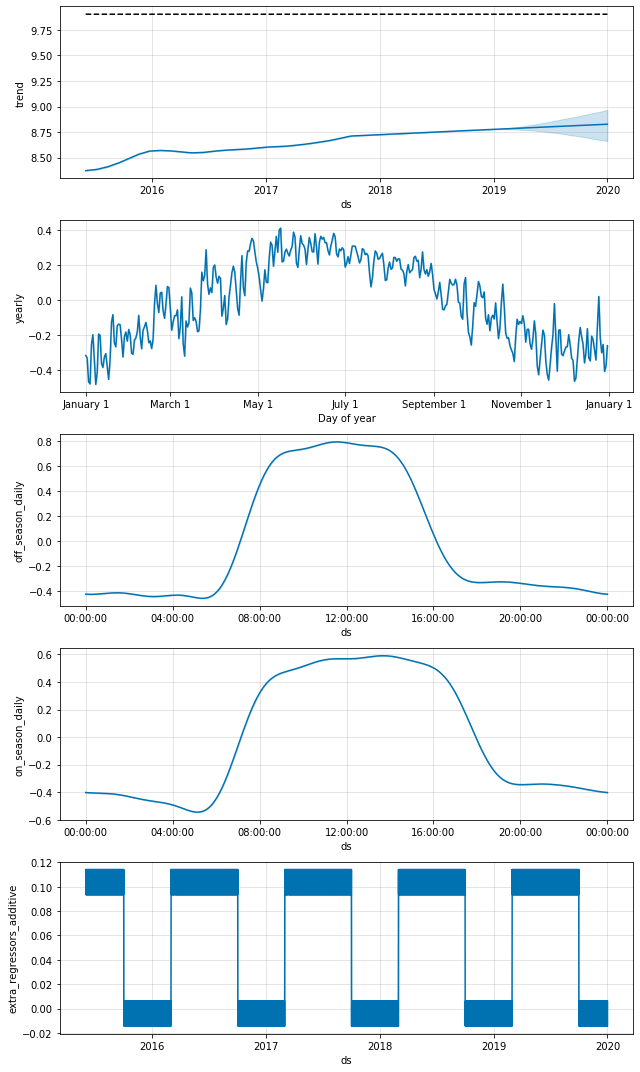

In [7]:
model.plot_components(forcast)

In [8]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

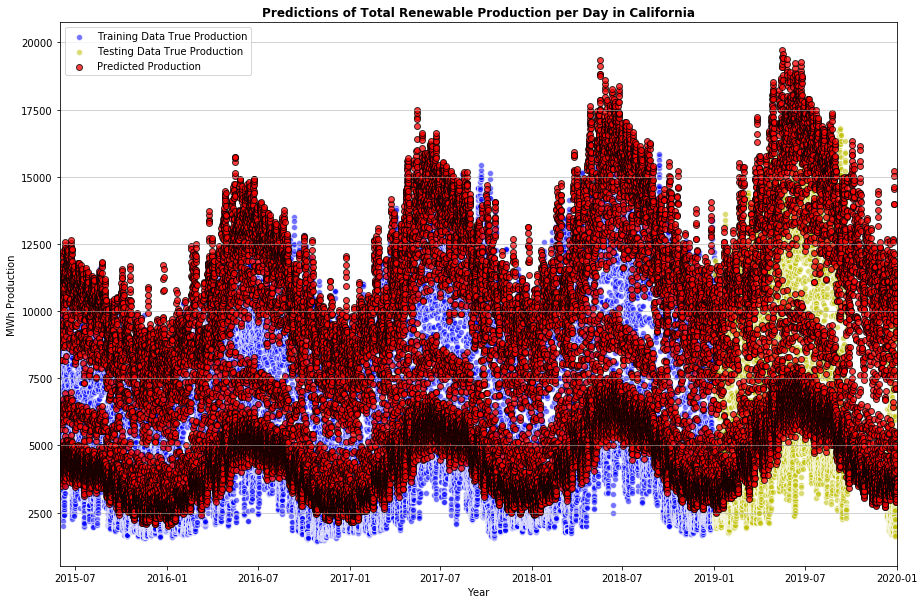

In [9]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  56081.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  7794.0


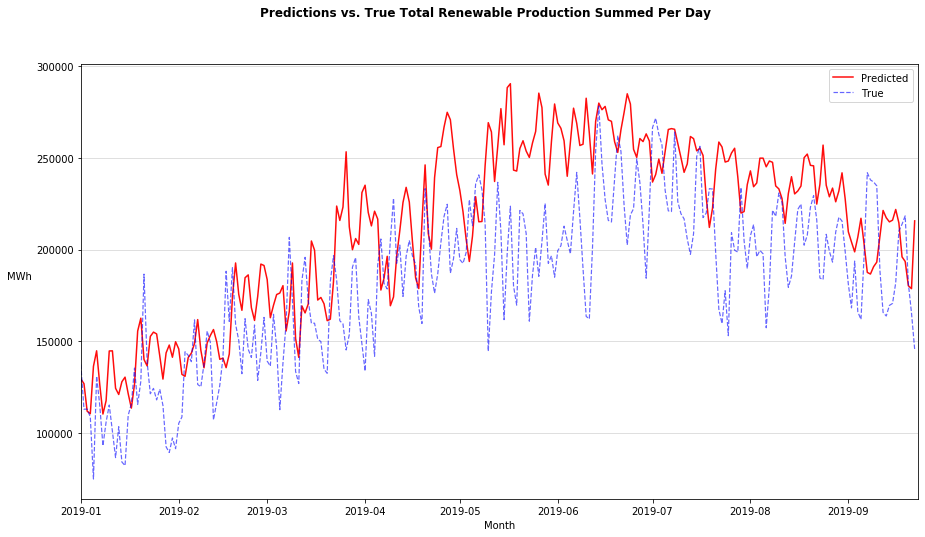

Train MAPE:  24.60935098526804
Train R2:  0.7936862387957793
Test MAPE:  28.621633245896675
Test R2:  0.7197932124997217


In [10]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])
#test data predictions and true values
tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),
                  how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)

#for plotting
dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values


#for plotting
datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'y'].values


month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))

plt.show()

#for calculations, training data
yhat_train = pd.DataFrame(forcast.loc[(forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[(dd['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])
#combine above two into one for calculations on training data 
tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum(np.nan_to_num(np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/true)),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [11]:
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['SOLAR TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd_s = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month > 3) & (date.month < 11)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month > 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1



dd_s.columns = ['ds','y']

scaler = StandardScaler()

dd_s['cap'] = np.cbrt(15000)
dd_s['floor'] = 0
#dd_s['cap'] = np.log(dd['cap'])

dd_s['on_season'] = dd_s['ds'].apply(on_season)
dd_s['off_season'] = ~dd_s['ds'].apply(on_season)
dd_s['daytime'] = dd_s['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd_s['on_seasonr'] = dd_s['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
#dd['y'] = dd['y'].replace(0,dd['y'].median())
dd_s['y'] = np.cbrt(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
#dd_s['y'] = np.log(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd_s['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd_s['daytime'] = scaler.fit_transform(daytimev)

dd_s_train = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2014'))&(dd_s['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_s_train.head(8))

dd_s_train.info()

ds          y        cap  floor  on_season  off_season  \
0 2015-06-01 00:00:00   0.000000  24.662121      0       True       False   
1 2015-06-01 01:00:00   0.000000  24.662121      0       True       False   
2 2015-06-01 02:00:00   0.000000  24.662121      0       True       False   
3 2015-06-01 03:00:00   0.000000  24.662121      0       True       False   
4 2015-06-01 04:00:00   0.000000  24.662121      0       True       False   
5 2015-06-01 05:00:00   0.000000  24.662121      0       True       False   
6 2015-06-01 06:00:00   8.494807  24.662121      0       True       False   
7 2015-06-01 07:00:00  13.787611  24.662121      0       True       False   

    daytime  on_seasonr  
0 -0.795932           1  
1 -0.795932           1  
2 -0.795932           1  
3 -0.795932           1  
4 -0.795932           1  
5 -0.795932           1  
6 -0.795932           1  
7 -0.795932           1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 8 columns):
ds            31392 non-null datetime64[ns]
y             31392 non-null float64
cap           31392 non-null float64
floor         31392 non-null int64
on_season     31392 non-null bool
off_season    31392 non-null bool
daytime       31392 non-null float64
on_seasonr    31392 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.7 MB


In [12]:
model = Prophet(changepoint_range=.35,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.5)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=8)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=8)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
#model.add_regressor('equinox')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_s_train)



In [13]:
futures = model.make_future_dataframe(periods=365*24,freq='1H')
futures['on_season'] = futures['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
futures['off_season'] = ~futures['ds'].apply(on_season)
futures['daytime'] = futures['ds'].apply(daytime)
futures['on_seasonr'] = futures['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
futures['cap'] = np.cbrt(15000)
futures['floor'] = 0
#futures['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = futures['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
futures['daytime'] = scaler.fit_transform(daytimef)

forcasts = model.predict(futures)

ds      trend        cap  floor  yhat_lower  \
40147 2019-12-31 19:00:00  10.395524  24.662121      0   -1.904790   
40148 2019-12-31 20:00:00  10.395578  24.662121      0   -2.442239   
40149 2019-12-31 21:00:00  10.395633  24.662121      0   -2.399493   
40150 2019-12-31 22:00:00  10.395687  24.662121      0   -2.139247   
40151 2019-12-31 23:00:00  10.395741  24.662121      0   -2.655362   

       yhat_upper  trend_lower  trend_upper  additive_terms  \
40147    3.297053     9.406872    11.435140       -9.826029   
40148    2.539602     9.406923    11.435427      -10.361683   
40149    2.613431     9.406971    11.435686      -10.344428   
40150    3.004157     9.406921    11.435840      -10.118390   
40151    2.553663     9.406871    11.435995      -10.482109   

       additive_terms_lower  ...  on_seasonr  on_seasonr_lower  \
40147             -9.826029  ...         0.0               0.0   
40148            -10.361683  ...         0.0               0.0   
40149            -10.344428  ...         0.0               0.0   
40150            -10.118390  ...         0.0               0.0   
40151            -10.482109  ...         0.0               0.0   

       on_seasonr_upper    yearly  yearly_lower  yearly_upper  \
40147               0.0 -3.556859     -3.556859     -3.556859   
40148               0.0 -3.549802     -3.549802     -3.549802   
40149               0.0 -3.539251     -3.539251     -3.539251   
40150               0.0 -3.525376     -3.525376     -3.525376   
40151               0.0 -3.508374     -3.508374     -3.508374   

       multiplicative_terms  multiplicative_terms_lower  \
40147                   0.0                         0.0   
40148                   0.0                         0.0   
40149                   0.0                         0.0   
40150                   0.0                         0.0   
40151                   0.0                         0.0   

       multiplicative_terms_upper      yhat  
40147                         0.0  0.569496  
40148                         0.0  0.033895  
40149                         0.0  0.051205  
40150                         0.0  0.277297  
40151                         0.0 -0.086369  

[5 rows x 33 columns]

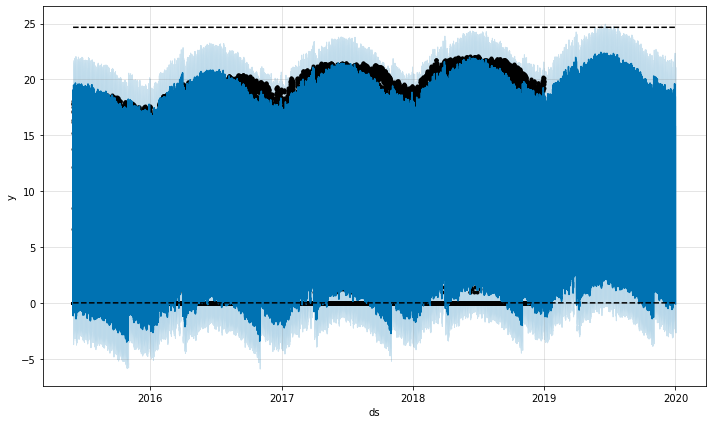

In [14]:
model.plot(forcasts)
forcasts.tail()

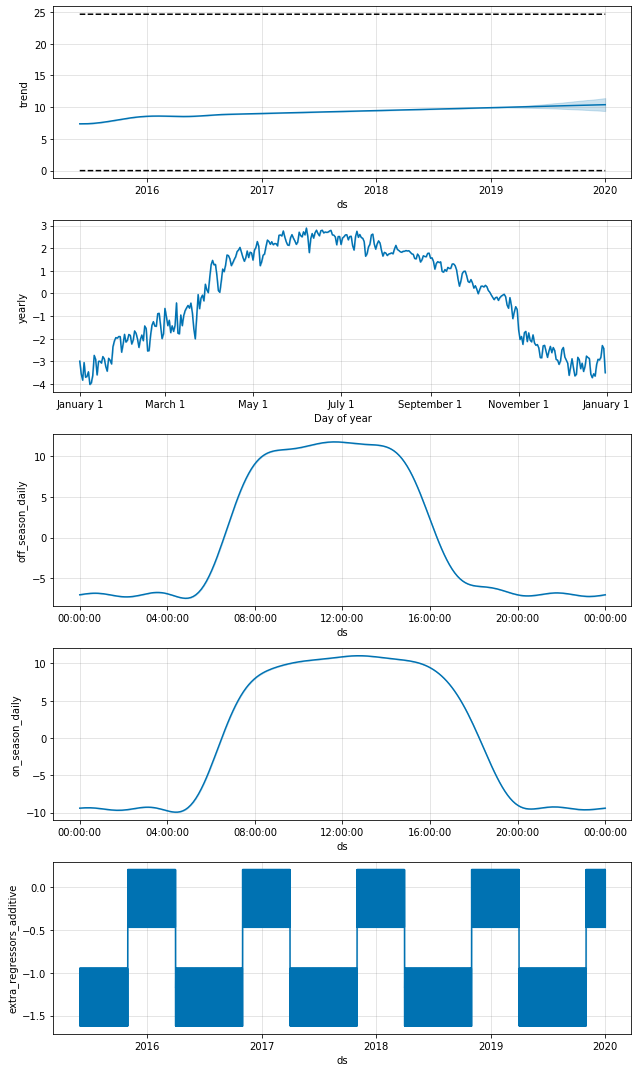

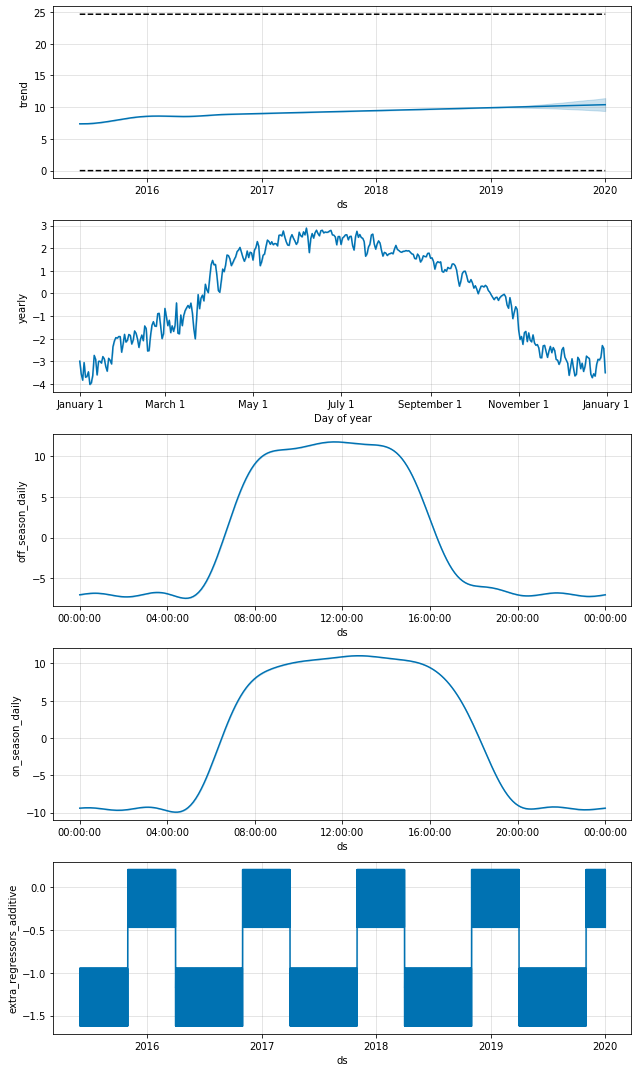

In [15]:
model.plot_components(forcasts)

In [16]:
#dd_s['y'] = np.exp(dd['y'])
dd_s['y'] = (dd_s['y'])**3
#dd_s_train['y'] = np.exp(dd_s_train['y'])
dd_s_train['y'] = (dd_s_train['y'])**3
#forcasts['yhst'] = np.exp(forcast['yhat'])
forcasts['yhat'] = (forcasts['yhat'])**3
dd_s_test = dd_s.loc[dd_s['ds']>pd.to_datetime('01/01/2019')]

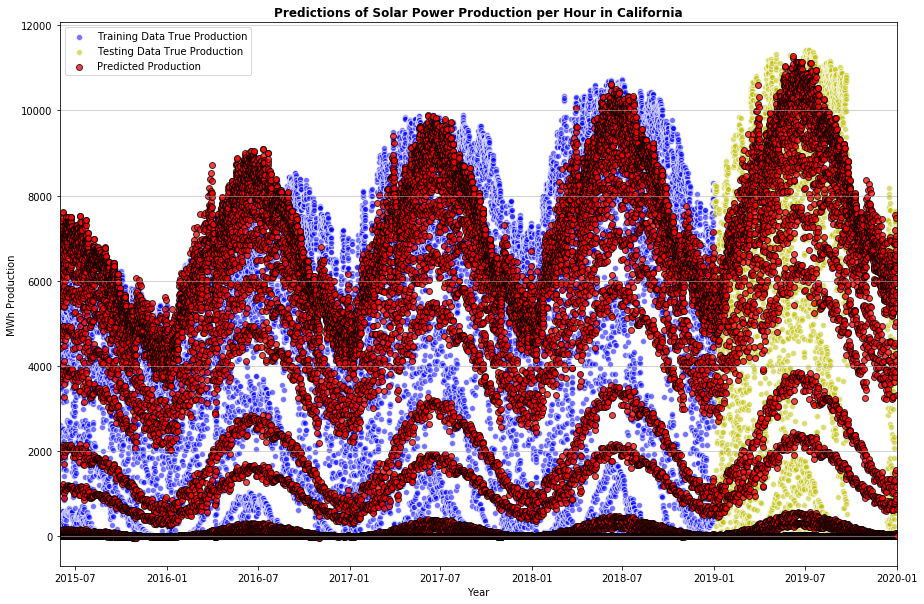

In [17]:

plt.figure(figsize=(15,10))

plt.scatter(dd_s_train['ds'],dd_s_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_s_test['ds'],dd_s_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcasts['ds'],forcasts['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Solar Power Production per Hour in California",fontweight='bold')
plt.show()

Predicted total solar Production 2017:  21033.0
True total solar Production 2017:  22684.0
Error in year total prediction in GWh:  -1652.0


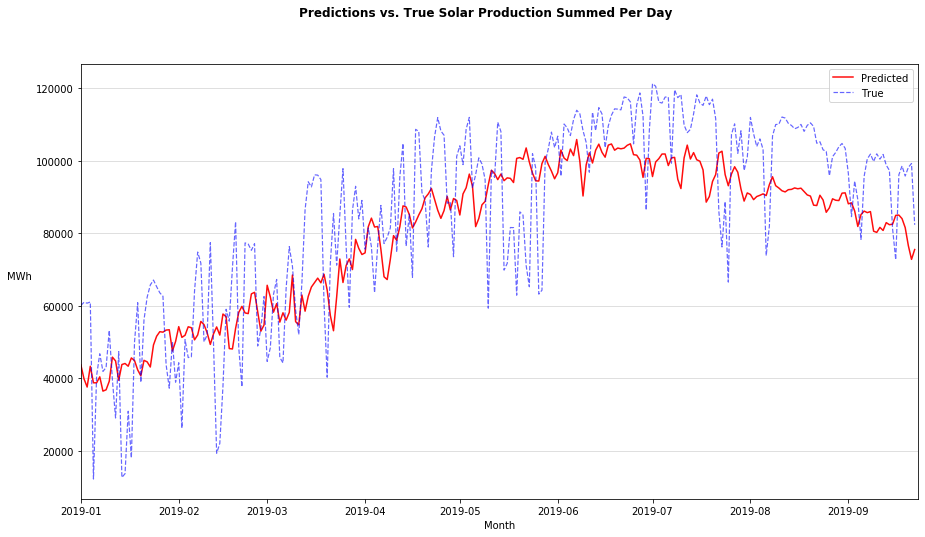

C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning:

divide by zero encountered in double_scalars



Test MAPE:  inf
Train R2:  0.9309473739510973
Test MAPE:  28.621633245896675
Test R2:  0.9148666898648115


In [18]:
yhats = pd.DataFrame(forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                                   (forcasts['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
trues = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (dd_s['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

testers = pd.merge(yhats.set_index(pd.DatetimeIndex(yhats['ds'])),(trues.set_index(pd.DatetimeIndex(trues['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted total solar Production 2017: ',(testers['yhat'].sum())//1000)
print('True total solar Production 2017: ',testers['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (testers['yhat'].sum()-testers['y'].sum())//1000)


datafs = forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                       (forcasts['ds'] < pd.to_datetime('09/23/2019'))),:].\
set_index(pd.DatetimeIndex(forcasts.loc[((forcasts['ds'] >= pd.to_datetime\
                                          ('01/01/2019')) & (forcasts['ds'] \
                                                             < pd.to_datetime\
                                                             ('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values



datats = dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                   (dd_s['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd_s['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'y'].values

month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,datafs,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datats,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Solar Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
#plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_trains = pd.DataFrame(forcasts.loc[\
                                         (forcasts['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_trains = pd.DataFrame(dd_s.loc[\
                                     (dd_s['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_trains = pd.merge(yhat_trains.set_index(pd.DatetimeIndex(yhat_trains['ds'])),(true_trains.set_index(pd.DatetimeIndex(true_trains['ds']))),how='left',left_index=True,right_index=True)


tester_trains['msem'] = ((tester_trains['y']-tester_trains['yhat'])**2)
tester_trains['mseb'] = (tester_trains['y']-tester_trains['y'].mean())**2
r2 = 1 - ((np.sum(tester_trains['msem'])/len(tester_trains))/(np.sum(tester_trains['mseb'])/len(tester_trains)))
true_trains = tester_trains['y'].values
yhat_trains = tester_trains['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/np.nan_to_num(true))),true_trains,yhat_trains)))*(100/len(true_trains))
print('Test MAPE: ', mape)
print('Train R2: ',r2)


testers['msem'] = ((testers['y']-testers['yhat'])**2)
testers['mseb'] = (testers['y']-testers['y'].mean())**2
r2 = 1 - ((np.sum(testers['msem'])/len(testers))/(np.sum(testers['mseb'])/len(testers)))
true_tests = testers['y'].values
yhat_tests = testers['yhat'].values
mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/(true))),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [19]:
 
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']

daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 3) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month > 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

dd_sm = forcasts.loc[:,['ds','yhat']]
print('''forcasts.loc[:,['ds','yhat']].head()''')
display(forcasts.loc[:,['ds','yhat']].head())

dd = pd.merge(dd.set_index(pd.DatetimeIndex(dd['ds'])),(dd_sm.set_index(pd.DatetimeIndex(dd_sm['ds']))),
              how='left',left_index=True,right_index=True)
dd = dd.reset_index()
dd.drop(columns=['ds_x','ds_y'],inplace=True)
dd.columns = ['ds','y','solar']
display(dd.head())


scaler = StandardScaler()

dd['cap'] = 25000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_seasonr'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

solarv = dd['solar'].values
solarv = solarv.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)
dd['solar'] = scaler.fit_transform(solarv)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2014'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))

dd_train.info()

forcasts.loc[:,['ds','yhat']].head()


ds      yhat
0 2015-06-01 00:00:00 -0.561873
1 2015-06-01 01:00:00 -0.740329
2 2015-06-01 02:00:00 -1.237271
3 2015-06-01 03:00:00 -0.321796
4 2015-06-01 04:00:00 -1.551757

ds     y     solar
0 2015-06-01 00:00:00  4669 -0.561873
1 2015-06-01 01:00:00  4396 -0.740329
2 2015-06-01 02:00:00  4197 -1.237271
3 2015-06-01 03:00:00  4059 -0.321796
4 2015-06-01 04:00:00  3694 -1.551757

ds         y     solar        cap  on_season  off_season  \
0 2015-06-01 00:00:00  8.448700 -0.800941  10.126631       True       False   
1 2015-06-01 01:00:00  8.388450 -0.800995  10.126631       True       False   
2 2015-06-01 02:00:00  8.342125 -0.801144  10.126631       True       False   
3 2015-06-01 03:00:00  8.308692 -0.800869  10.126631       True       False   
4 2015-06-01 04:00:00  8.214465 -0.801238  10.126631       True       False   
5 2015-06-01 05:00:00  8.228978 -0.800831  10.126631       True       False   
6 2015-06-01 06:00:00  8.365905 -0.766471  10.126631       True       False   
7 2015-06-01 07:00:00  8.716372 -0.242774  10.126631       True       False   

    daytime  on_seasonr  
0 -0.795932           1  
1 -0.795932           1  
2 -0.795932           1  
3 -0.795932           1  
4 -0.795932           1  
5 -0.795932           1  
6 -0.795932           1  
7 -0.795932           1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 8 columns):
ds            31392 non-null datetime64[ns]
y             31392 non-null float64
solar         31392 non-null float64
cap           31392 non-null float64
on_season     31392 non-null bool
off_season    31392 non-null bool
daytime       31392 non-null float64
on_seasonr    31392 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(4), int64(1)
memory usage: 1.7 MB


In [20]:
model = Prophet(changepoint_range=.45,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.52)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=3)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=3)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
model.add_regressor('solar')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_train)



In [21]:
future = model.make_future_dataframe(periods=365*24,freq='1H')

dd_smf = forcasts.loc[:,['ds','yhat']]

future = pd.merge(future.set_index(pd.DatetimeIndex(future['ds'])),(dd_smf.set_index(pd.DatetimeIndex(dd_smf['ds']))),how='left',left_index=True,right_index=True)
future = future.reset_index()
future.drop(columns=['ds_x','ds_y'],inplace=True)

future.info()
future.loc[(future['ds'] > pd.to_datetime('09/23/2019'))&(future['ds']< pd.to_datetime('12/16/2019'))].tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40152 entries, 0 to 40151
Data columns (total 2 columns):
ds      40152 non-null datetime64[ns]
yhat    40152 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 627.5 KB


ds      yhat
39763 2019-12-15 19:00:00  0.927058
39764 2019-12-15 20:00:00  0.073213
39765 2019-12-15 21:00:00  0.068721
39766 2019-12-15 22:00:00  0.221488
39767 2019-12-15 23:00:00  0.008800

In [22]:
future.rename(columns={
    'yhat':'solar'
}, inplace=True)
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 25000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

solarf = future['solar'].values
solarf = solarf.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)
future['solar'] = scaler.fit_transform(solarf)

display(future.head())


ds     solar  on_season  off_season   daytime  on_seasonr  \
0 2015-06-01 00:00:00 -0.801017       True       False -0.795932           1   
1 2015-06-01 01:00:00 -0.801070       True       False -0.795932           1   
2 2015-06-01 02:00:00 -0.801220       True       False -0.795932           1   
3 2015-06-01 03:00:00 -0.800944       True       False -0.795932           1   
4 2015-06-01 04:00:00 -0.801315       True       False -0.795932           1   

         cap  
0  10.126631  
1  10.126631  
2  10.126631  
3  10.126631  
4  10.126631

In [23]:
forcast = model.predict(future)

ds     trend        cap  yhat_lower  yhat_upper  \
40147 2019-12-31 19:00:00  8.717219  10.126631    7.519753    8.634728   
40148 2019-12-31 20:00:00  8.717227  10.126631    7.449264    8.558478   
40149 2019-12-31 21:00:00  8.717234  10.126631    7.484216    8.520282   
40150 2019-12-31 22:00:00  8.717241  10.126631    7.483331    8.580448   
40151 2019-12-31 23:00:00  8.717249  10.126631    7.559112    8.557245   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  \
40147     8.228670     9.113142       -0.597972             -0.597972   
40148     8.228556     9.113213       -0.656007             -0.656007   
40149     8.228442     9.113284       -0.651061             -0.651061   
40150     8.228328     9.113354       -0.636819             -0.636819   
40151     8.228214     9.113425       -0.631555             -0.631555   

       additive_terms_upper  ...     solar  solar_lower  solar_upper  \
40147             -0.597972  ... -0.162598    -0.162598    -0.162598   
40148             -0.656007  ... -0.162610    -0.162610    -0.162610   
40149             -0.651061  ... -0.162610    -0.162610    -0.162610   
40150             -0.636819  ... -0.162609    -0.162609    -0.162609   
40151             -0.631555  ... -0.162610    -0.162610    -0.162610   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
40147 -0.225345     -0.225345     -0.225345                   0.0   
40148 -0.227385     -0.227385     -0.227385                   0.0   
40149 -0.229713     -0.229713     -0.229713                   0.0   
40150 -0.232296     -0.232296     -0.232296                   0.0   
40151 -0.235098     -0.235098     -0.235098                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper      yhat  
40147                         0.0                         0.0  8.119247  
40148                         0.0                         0.0  8.061220  
40149                         0.0                         0.0  8.066173  
40150                         0.0                         0.0  8.080423  
40151                         0.0                         0.0  8.085694  

[5 rows x 35 columns]

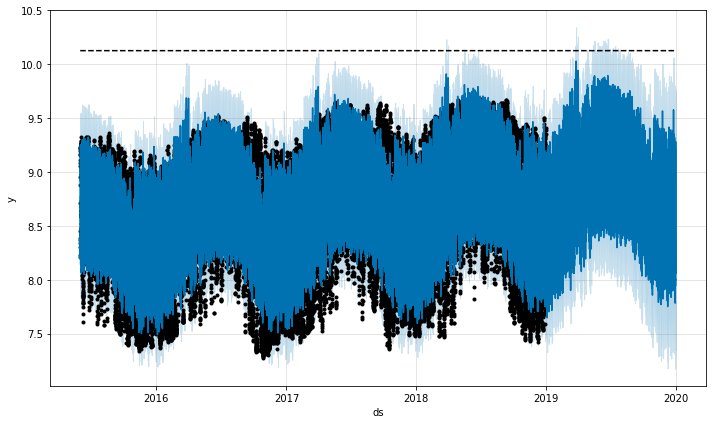

In [24]:
model.plot(forcast)
forcast.tail()

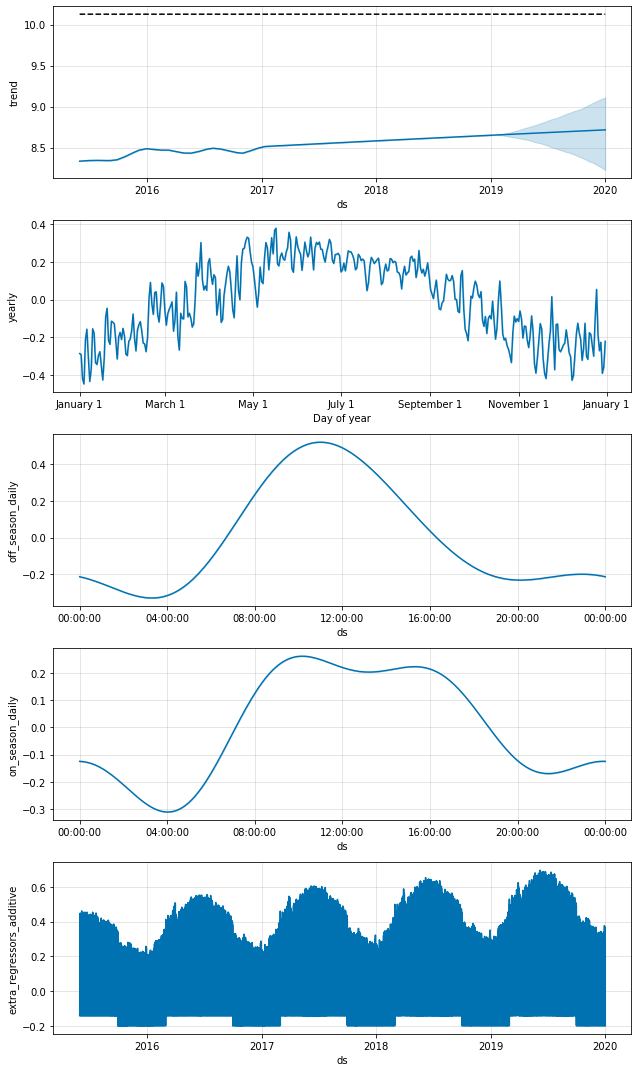

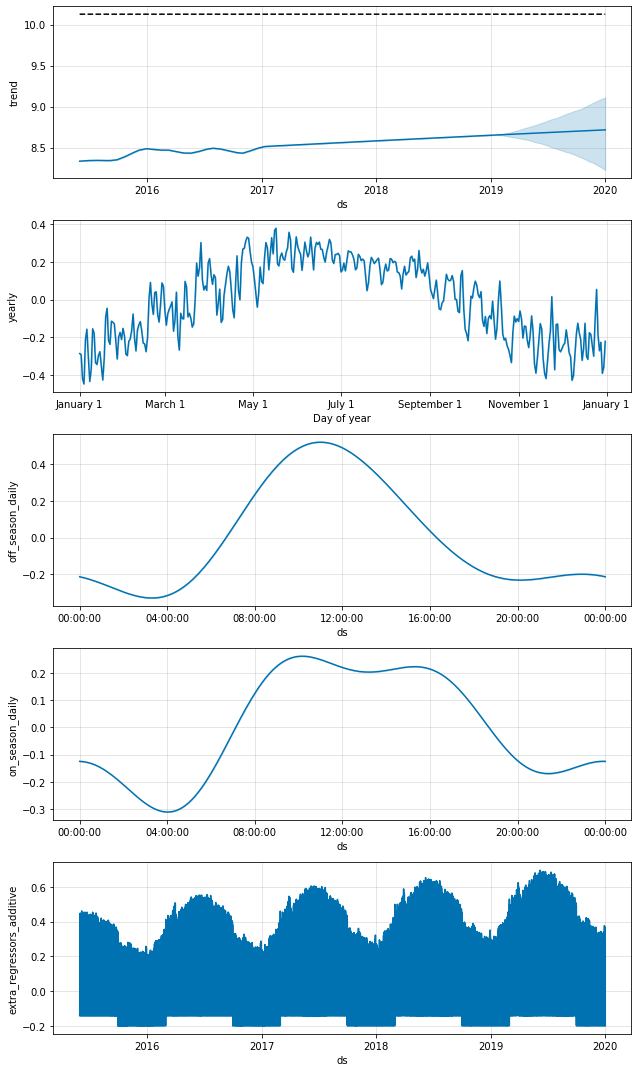

In [25]:
model.plot_components(forcast)

In [26]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

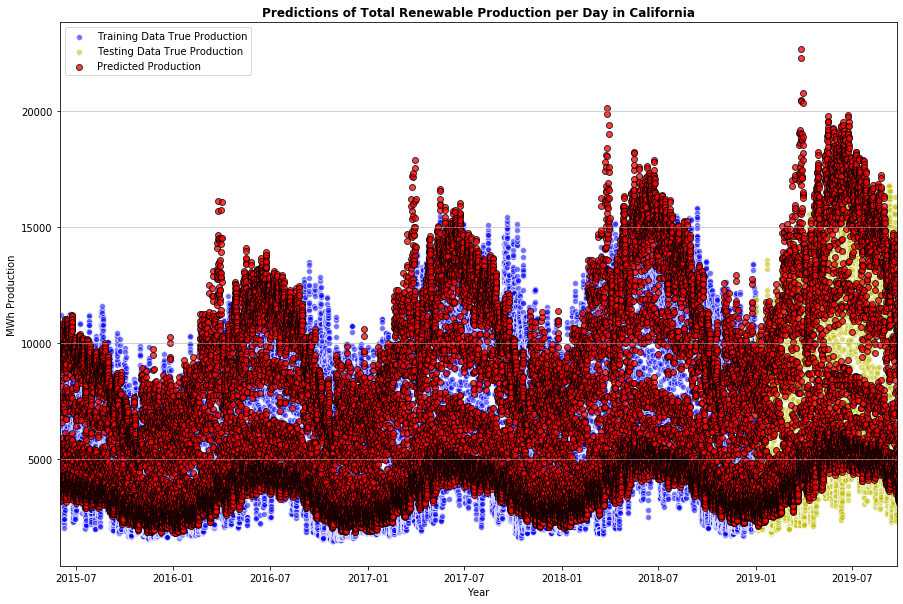

In [27]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('09/23/2019'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  51375.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  3088.0


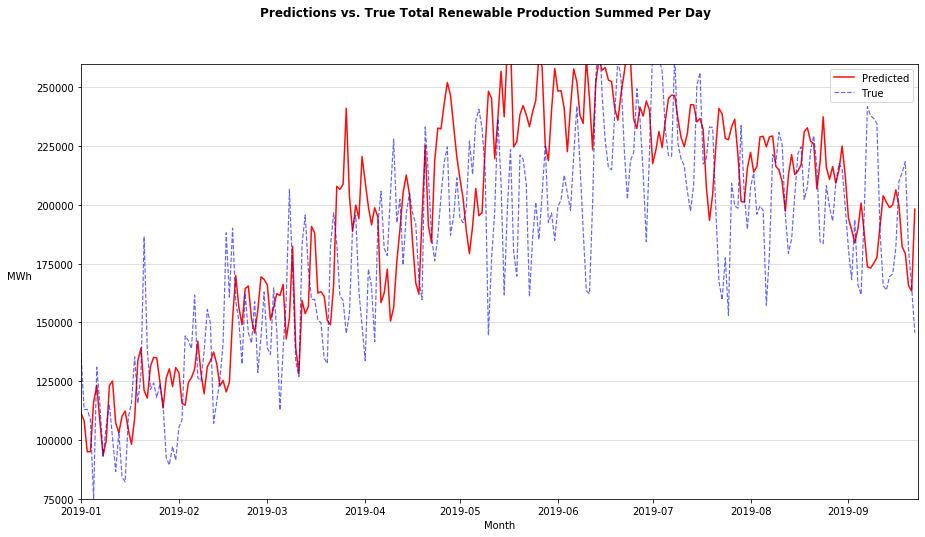

Train MAPE:  19.61198761380073
Train R2:  0.8432109335266548
Test MAPE:  22.512960178570594
Test R2:  0.7463999446081272


In [28]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'yhat'].values


datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('24H').sum().loc[:,'y'].values



month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_train = pd.DataFrame(forcast.loc[\
                                       (forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[\
                                  (dd['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/np.nan_to_num(true))),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [29]:
forcast['solar'] = forcasts['yhat']
predictions = forcast.loc[:,['ds','solar','yhat']]
predictions.rename(columns={
    'ds':'timestamp',
    'solar':'Pred Solar Prod',
    'yhat':'Pred Tot Renew Prod'
}, inplace=True)
predictions['Hour'] = predictions['timestamp'].dt.hour
predictions = predictions[['timestamp','Hour','Pred Tot Renew Prod','Pred Solar Prod']]
predictions.head(24)

timestamp  Hour  Pred Tot Renew Prod  Pred Solar Prod
0  2015-06-01 00:00:00     0          4405.453451        -0.561873
1  2015-06-01 01:00:00     1          4285.453934        -0.740329
2  2015-06-01 02:00:00     2          4019.774233        -1.237271
3  2015-06-01 03:00:00     3          3745.502084        -0.321796
4  2015-06-01 04:00:00     4          3616.216761        -1.551757
5  2015-06-01 05:00:00     5          3736.459750        -0.196712
6  2015-06-01 06:00:00     6          4174.264079       114.269215
7  2015-06-01 07:00:00     7          5399.255188      1858.870153
8  2015-06-01 08:00:00     8          7610.539967      4422.741387
9  2015-06-01 09:00:00     9          9140.817986      5791.037682
10 2015-06-01 10:00:00    10          9896.226240      6507.021837
11 2015-06-01 11:00:00    11          9990.122328      6890.014306
12 2015-06-01 12:00:00    12         10369.870585      6787.900850
13 2015-06-01 13:00:00    13         10267.464375      6935.980767
14 2015-06-01 14:00:00    14         10101.228881      6639.881924
15 2015-06-01 15:00:00    15          9976.597743      6289.344642
16 2015-06-01 16:00:00    16          9329.252697      5401.354953
17 2015-06-01 17:00:00    17          7327.892066      3623.187896
18 2015-06-01 18:00:00    18          5666.806121      1059.141492
19 2015-06-01 19:00:00    19          4761.062687        49.764947
20 2015-06-01 20:00:00    20          4173.363054        -0.003329
21 2015-06-01 21:00:00    21          3987.769410        -0.159769
22 2015-06-01 22:00:00    22          3993.467991        -0.059481
23 2015-06-01 23:00:00    23          4091.692741        -0.343671

In [30]:
# name = 'hourlyrenewablepredictions'
# schema = 'Predictions'

# with engine.connect() as c:
#     c.execute('''CREATE SCHEMA "Predictions"''')

# predictions.to_sql(name=name, con=con, schema=schema, if_exists='replace',index=False)

In [31]:
# with engine.connect() as c:
#     c.execute('''ALTER TABLE "Predictions".hourlyrenewablepredictions 
#     ADD PRIMARY KEY ("timestamp")''')

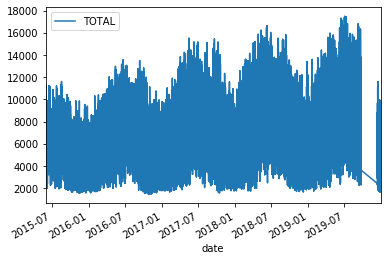

In [32]:
full_data.plot(x='date',
              y='TOTAL')

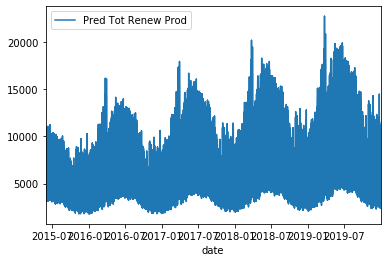

In [33]:
predictions['date'] = pd.to_datetime(predictions['timestamp']).dt.date
predictions.plot(x='date',
              y='Pred Tot Renew Prod')

In [34]:
from sklearn.metrics import mean_absolute_error as MAE
#train Mean Absolute Error 
MAE(tester_train['y'], tester_train['yhat'])

1022.8909062414411

In [35]:
#test mae
MAE(tester['y'], tester['yhat'])

1502.8040901444572

Predicted Total Renewable Production 2019:  51375.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  3088.0


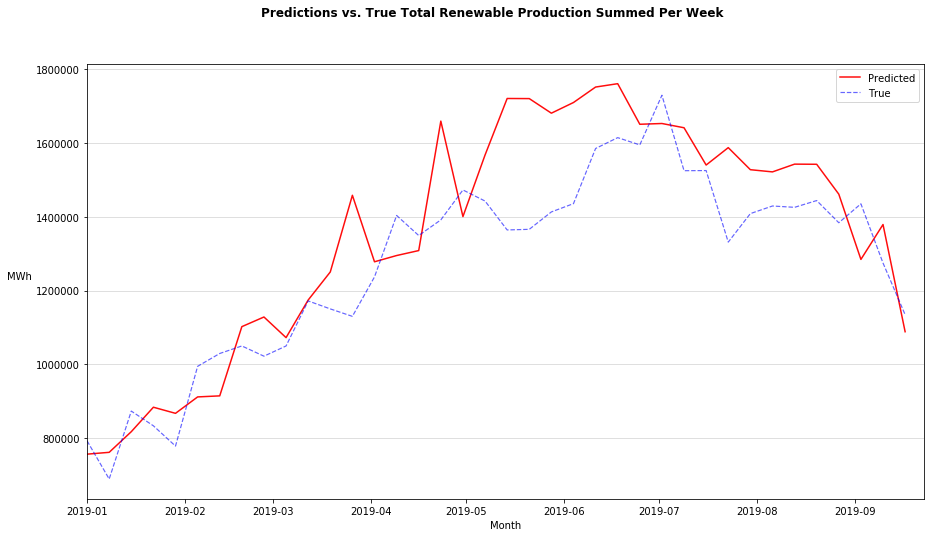

In [36]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('7D').sum().loc[:,'yhat'])


datat = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('7D').sum().loc[:,'y'])



month_list = pd.date_range('01/01/2019','09/23/2019',freq='1M')


plt.figure(figsize=(15,8))
plt.plot(dataf.index,dataf.reset_index()['yhat'],label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(datat.index,datat.reset_index()['y'],label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Week',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
# plt.ylim(bottom=75000,top=260000)
plt.show()




(50000, 282467.6416759977)

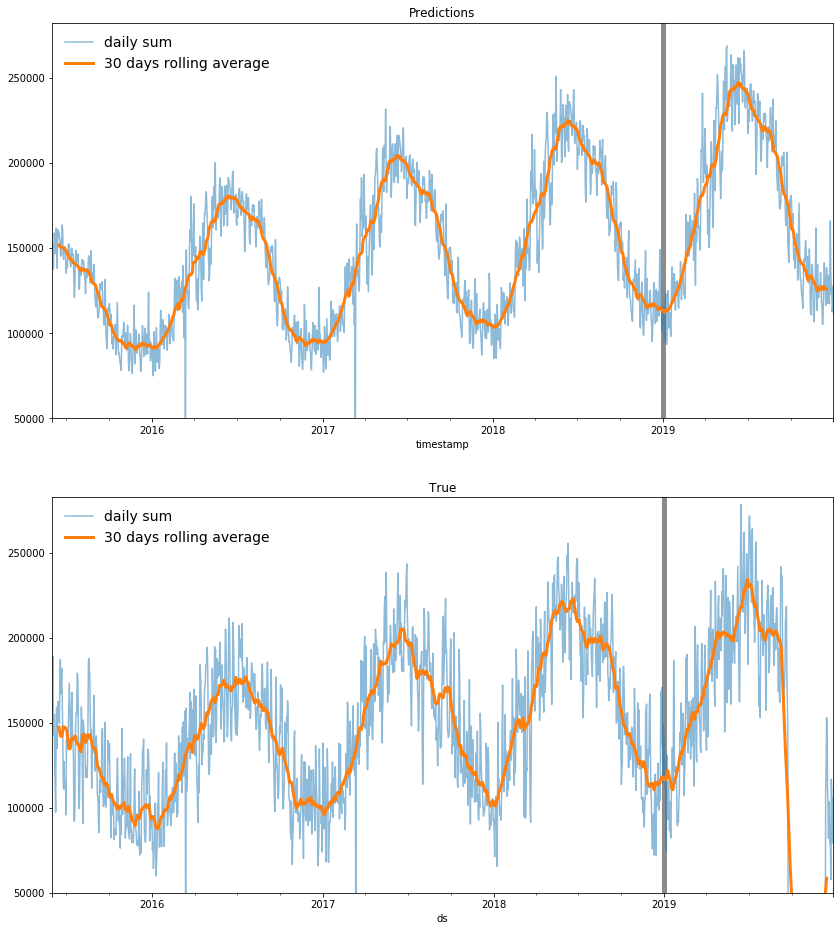

In [37]:
data = pd.DataFrame(predictions['Pred Tot Renew Prod']).set_index(pd.DatetimeIndex(predictions['timestamp'])).resample('1D').sum()
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(nrows=2, figsize=(14,16), sharey=True)

ax = axes[0]

data.plot(ax=ax, alpha=0.5, title="Predictions")
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3)
ax.legend(['daily sum','30 days rolling average'], frameon=False, fontsize=14)
ax.axvline(pd.to_datetime('2019-01-01'),lw=5,color='k',alpha=.45,zorder=-1)
ax.set_ylim(bottom=50000)

ax = axes[1]

data = pd.DataFrame(dd['y']).set_index(pd.DatetimeIndex(dd['ds'])).resample('1D').sum()
data.plot(ax=ax, alpha=0.5, title="True")
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3)
ax.legend(['daily sum','30 days rolling average'], frameon=False, fontsize=14)
ax.axvline(pd.to_datetime('2019-01-01'),lw=5,color='k',alpha=.45,zorder=-1)
ax.set_ylim(bottom=50000)


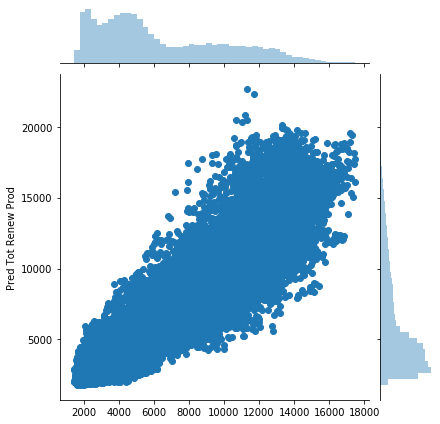

In [38]:

sns.jointplot(x=full_data.loc[full_data['date'] < pd.to_datetime('09/23/2019'),'TOTAL'].values,y=predictions.loc[predictions['timestamp'] < pd.to_datetime('09/23/2019'),
                                                                                         'Pred Tot Renew Prod'])